This script makes plot of some tripping in a non clear sky day to demonstrate that tripping is really bad not only in clear sky day but also in a non clear sky days

# IMPORT MODULES & FUNCTIONS

In [1]:
#IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
import calendar
import seaborn as sns; sns.set()
import itertools
#import datetime
from time import gmtime, strftime
from matplotlib import cm
from IPython.display import display
#%matplotlib qt
#%matplotlib inline

#SET GLOBAL PARAMETERS
# ================== Global parameters for fonts & sizes =================
FONT_SIZE = 20
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': FONT_SIZE, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

from solarcurtailment.energy_calculation import *
from solarcurtailment.clear_sky_day import *
from solarcurtailment.tripping_curt import *
from solarcurtailment.vvar_curt import *
from solarcurtailment.vwatt_curt import *
from solarcurtailment.polyfit import *
from solarcurtailment.file_processing import *
from solarcurtailment.data_visualization import *

#class instantiation
file_processing = FileProcessing()
clear_sky_day = ClearSkyDay()
data_visualization = DataVisualization()
energy_calculation = EnergyCalculation()
tripping_curt = TrippingCurt()
polyfit_f = Polyfit()
vvar_curt = VVarCurt()
vwatt_curt = VWattCurt()

#from FileProcessing 
def input_monthly_files(file_path, data_date_idx):
    """Open time-series D-PV data and ghi data of a certain month. Only compatible for SoLA data format.

    Args:
        file_path (str): The file location of the data
        data_date_idx (str): The month of the files in format 'YYYYMM' eg '201907'

    Returns:
        data (df): the opened & cleaned time-series D-PV data
        ghi (df): the opened & cleaned ghi data
        data_ori (df): the opened & unmodified time-series D-PV data
        ghi_ori (df): the opened & unmodified ghi data
    """
    
    data_path = file_path + r"/processed_unsw_" + data_date_idx + '_data_raw.csv'
    data_ori = pd.read_csv(data_path)
    data = data_ori.set_index('utc_tstamp')

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"/sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 
    ghi_ori = ghi.copy()

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    
    return data, ghi, data_ori, ghi_ori

C:\Users\samha\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# CHECK ALL DAYS
Find list of all dates which data are available

In [2]:
def create_date_list(year, month, num_of_days):
    """Create a list of date as str for certain month and year.

    Args:
        year (str): year
        month (str): month
        num_of_days (int): number of days for a certain month and year. 

    Returns:
        date_list (list): list of date as str
    """
    
    date_list = []
    
    for i in range(1, 10):
        date_list.append(year + '-' + month + '-0'  + str(i))
    for i in range(10, num_of_days + 1):
        date_list.append(year + '-' + month + '-'  + str(i))
    
    return date_list

In [3]:
datelist_201909 = create_date_list('2019', '09', 30)
datelist_201910 = create_date_list('2019', '10', 31)
datelist_201911 = create_date_list('2019', '11', 30)
datelist_201912 = create_date_list('2019', '12', 31)
datelist_202001 = create_date_list('2020', '01', 31)
datelist_202002 = create_date_list('2020', '02', 29)
datelist_202003 = create_date_list('2020', '03', 31)
datelist_202004 = create_date_list('2020', '04', 30)


date_list = datelist_201909 + datelist_201910 + datelist_201911 + datelist_201912 + datelist_202001 + datelist_202002 + datelist_202003 + datelist_202004

# CLEAR SKY DAYS LIST

In [4]:
csd_201909 = ['2019-09-12', '2019-09-17', '2019-09-18', '2019-09-26', '2019-09-29', '2019-09-30']
csd_201910 = ['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-29']
csd_201911 = ['2019-11-18', '2019-11-27']
csd_201912 = ['2019-12-16', '2019-12-19', '2019-12-25', '2019-12-28']
csd_202001 = ['2020-01-01', '2020-01-02', '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-17', '2020-01-29', '2020-01-30']
csd_202002 = ['2020-02-04', '2020-02-05', '2020-02-06', '2020-02-10', '2020-02-11', '2020-02-13', '2020-02-22', '2020-02-23']
csd_202003 = ['2020-03-03', '2020-03-08', '2020-03-10', '2020-03-14', '2020-03-15', '2020-03-25', '2020-03-26']
csd_202004 = ['2020-04-08', '2020-04-09', '2020-04-13', '2020-04-24']

csd_list = csd_201909 + csd_201910 + csd_201911 + csd_201912 + csd_202001 + csd_202002 + csd_202003 + csd_202004

# INPUT MONTHLY DATA
October may be a very good candidate since it is spring. In spring, the PV production is not bad, but the load demand is very low compared to summer or winter. So, the network voltage is expected to be high

In [59]:
#file_path = r"/Users/samhan/Downloads/data" #for running in Samhan's laptop
file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer

month_list = ['201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004']
data = {}
data_ori = {}
ghi = {}
ghi_ori = {}
#for month in month_list:
month = '201910'
print('processing {} ...'.format(month))
data[month], ghi[month], data_ori[month], ghi_ori[month] = input_monthly_files(file_path, month)
data[month]['date'] = data[month].index.date
    
site_details, unique_cids= file_processing.input_general_files(file_path)

processing 201910 ...


# CHOOSE 5 GOOD SAMPLES

Date 2019-10-01


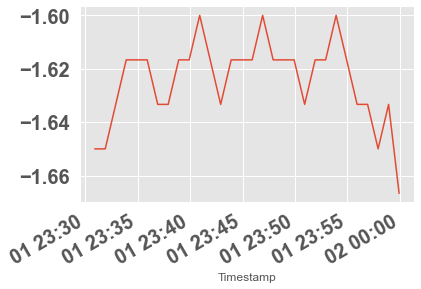

Date 2019-10-02


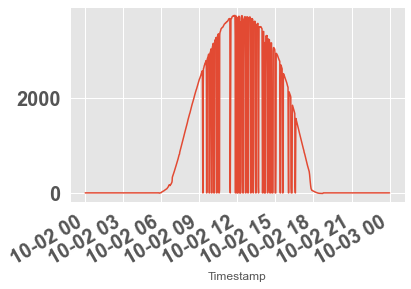

Date 2019-10-03


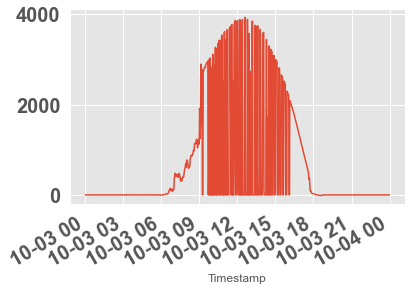

Date 2019-10-04


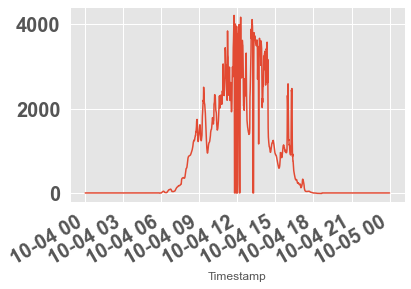

Date 2019-10-05


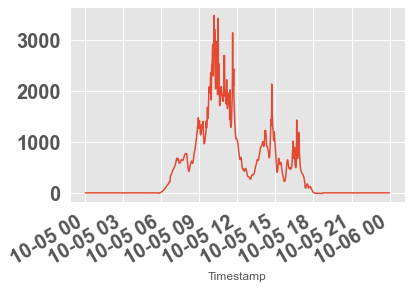

Date 2019-10-06


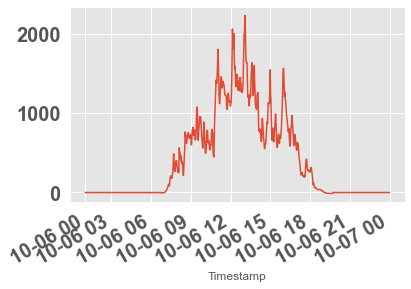

Date 2019-10-07


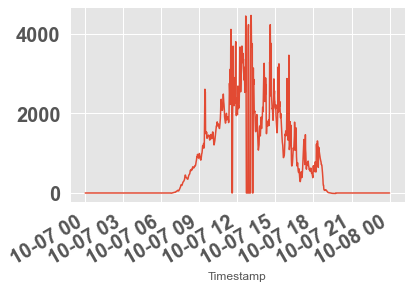

Date 2019-10-08


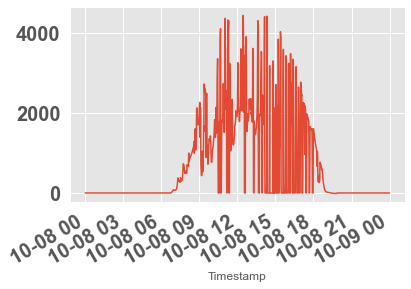

Date 2019-10-09


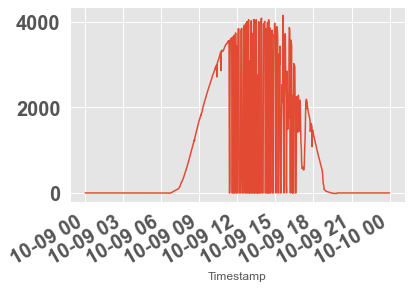

Date 2019-10-10


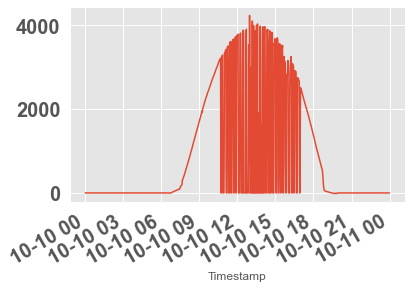

Date 2019-10-11


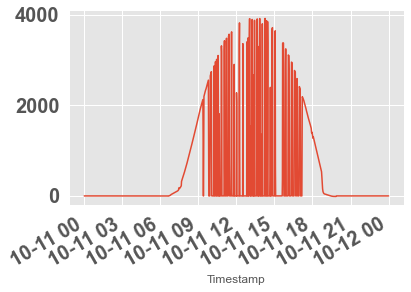

Date 2019-10-12


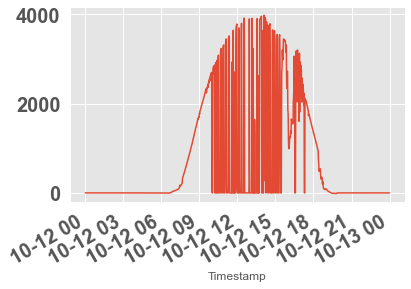

Date 2019-10-13


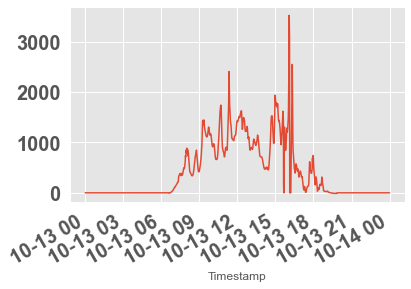

Date 2019-10-14


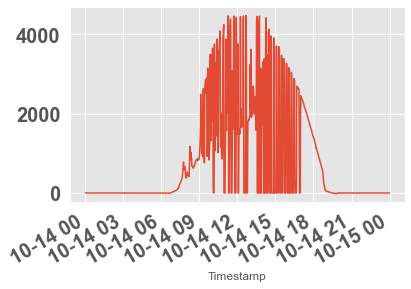

Date 2019-10-15


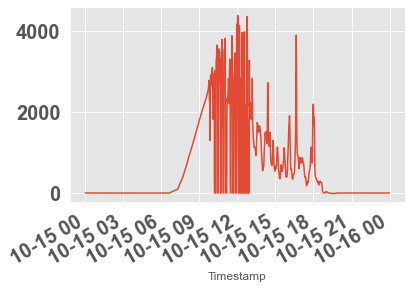

Date 2019-10-16


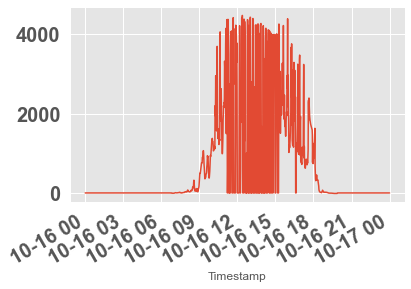

Date 2019-10-17


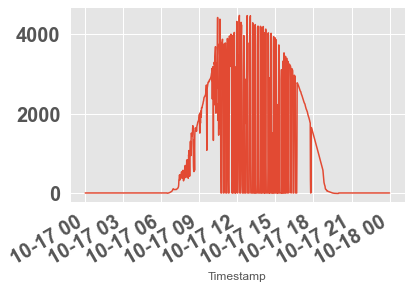

Date 2019-10-18


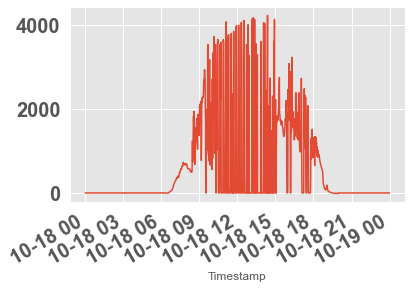

Date 2019-10-19


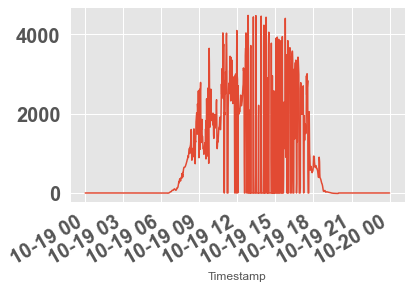

Date 2019-10-20


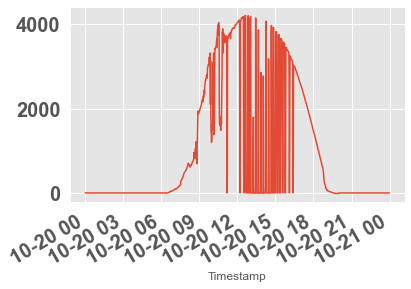

Date 2019-10-21


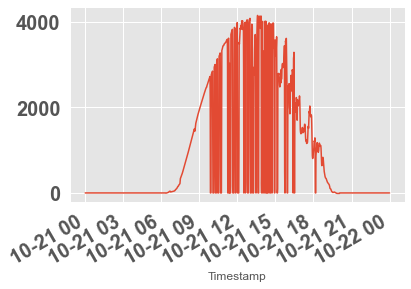

Date 2019-10-22


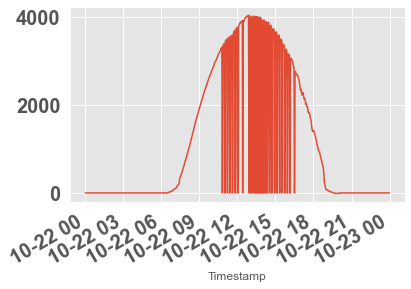

Date 2019-10-23


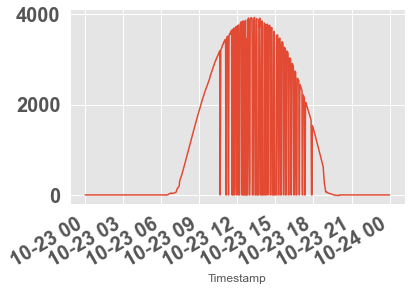

Date 2019-10-24


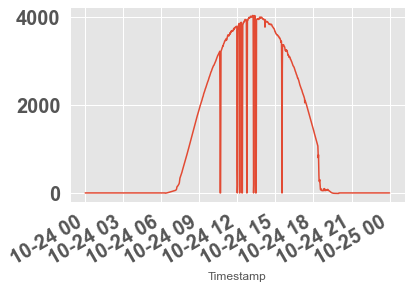

Date 2019-10-25


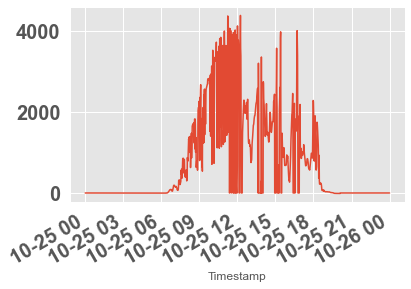

Date 2019-10-26


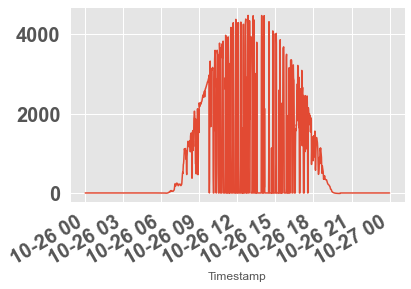

Date 2019-10-27


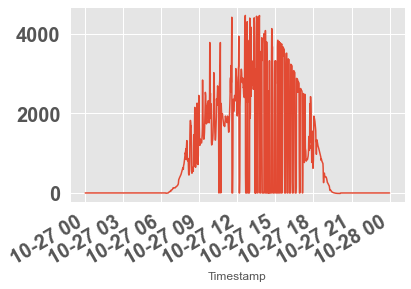

Date 2019-10-28


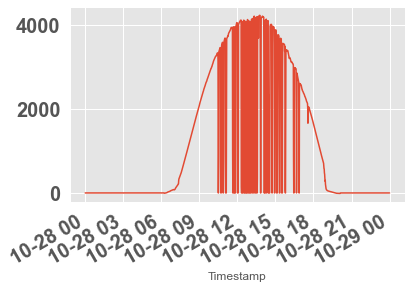

Date 2019-10-29


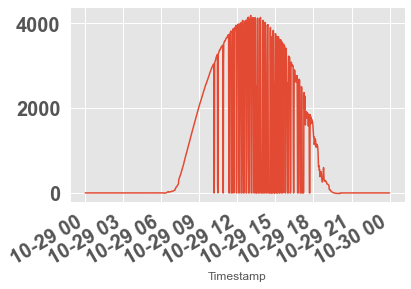

Date 2019-10-30


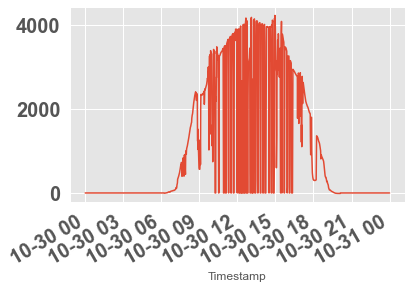

Date 2019-10-31


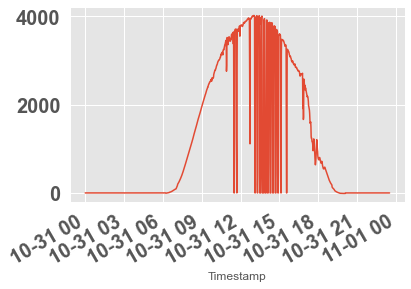

In [20]:
c_id = 1317822057
month_analyzed = '201910'
site_id_filter = data[month_analyzed]['c_id'] == c_id
data_certain_site = data[month_analyzed].loc[site_id_filter]

for date in datelist_201910:
    print('Date {}'.format(date))
    #filter D-PV time series data
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    date_filter = data_certain_site['date'] == date_dt
    data_analyzed = data_certain_site.loc[date_filter]
    
    data_analyzed['power'].plot()
    plt.show()

In [61]:
date_analyzed_tripping_ncsd = ['2019-10-08', '2019-10-09', '2019-10-10', '2019-10-11', '2019-10-15']

# PRODUCE THE PLOT

c_id  energy  power  reactive_power  voltage  \
ts                                                                        
2019-10-15 00:00:55  1317822057     -96    0.0       97.133333    238.8   
2019-10-15 00:01:55  1317822057     -96    0.0       96.500000    238.3   
2019-10-15 00:02:55  1317822057     -96    0.0       96.600000    238.7   
2019-10-15 00:03:55  1317822057     -96    0.0       97.100000    238.7   
2019-10-15 00:04:55  1317822057     -97    0.0       97.883333    240.8   
...                         ...     ...    ...             ...      ...   
2019-10-15 23:55:55  1317822057     -98    0.0      102.016667    243.3   
2019-10-15 23:56:55  1317822057     -99    0.0      101.166667    244.3   
2019-10-15 23:57:55  1317822057     -98    0.0      101.633333    243.8   
2019-10-15 23:58:55  1317822057     -97    0.0      100.716667    241.2   
2019-10-15 23:59:55  1317822057     -98    0.0       99.416667    241.7   

                     duration        date          va   pf  \
ts                                                           
2019-10-15 00:00:55        60  2019-10-15   97.133333  0.0   
2019-10-15 00:01:55        60  2019-10-15   96.500000  0.0   
2019-10-15 00:02:55        60  2019-10-15   96.600000  0.0   
2019-10-15 00:03:55        60  2019-10-15   97.100000  0.0   
2019-10-15 00:04:55        60  2019-10-15   97.883333  0.0   
...                       ...         ...         ...  ...   
2019-10-15 23:55:55        60  2019-10-15  102.016667  0.0   
2019-10-15 23:56:55        60  2019-10-15  101.166667  0.0   
2019-10-15 23:57:55        60  2019-10-15  101.633333  0.0   
2019-10-15 23:58:55        60  2019-10-15  100.716667  0.0   
2019-10-15 23:59:55        60  2019-10-15   99.416667  0.0   

                     power_expected_linear  power_expected  
ts                                                          
2019-10-15 00:00:55                    0.0             0.0  
2019-10-15 00:01:55                    0.0             0.0  
2019-10-15 00:02:55                    0.0             0.0  
2019-10-15 00:03:55                    0.0             0.0  
2019-10-15 00:04:55                    0.0             0.0  
...                                    ...             ...  
2019-10-15 23:55:55                    0.0             0.0  
2019-10-15 23:56:55                    0.0             0.0  
2019-10-15 23:57:55                    0.0             0.0  
2019-10-15 23:58:55                    0.0             0.0  
2019-10-15 23:59:55                    0.0             0.0  

[1430 rows x 11 columns]

In [121]:
def plot_curtailment(data_site, date, ac_cap):
    ''' Plot curtailment of a D-PV data
    
    Arg:
        data_site (df): D-PV data
        date (str) : the date
        ac_cap (int): ac capacity of the inverter
    
    Return:
        -
    
    '''
    
    data_site['power_normalized'] = data_site['power'] / ac_cap
    data_site['power_expected_normalized'] = data_site['power_expected'] / ac_cap
    data_site = data_site.between_time('6:00', '19:00')
    year = int(date[:4])
    month = int(date[5:7])
    day = int(date[8:10])

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    
    line2 = ax.plot(data_site['power_expected_normalized'], color = 'y', marker='.', label = 'Normalised DPV curtailment estimate', lw = 1)
    line1 = ax.plot(data_site['power_normalized'], color = 'tab:purple', marker='.', label = 'Normalised DPV power', lw = 1) 
    ax.fill_between(data_site.index, data_site['power_expected_normalized'], 0, color='y', alpha=1)
    ax.fill_between(data_site.index, data_site['power_normalized'], 0, color='tab:purple', alpha=1)
    
    ax.set_ylim([0, 1.2])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])    
    ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1', '1.2'])
    ax.set_ylabel('Normalized DPV power (kW/kW capacity)', **fontdict)
    ax.set_xlabel('Time ({})'.format(date), **fontdict)
    ax.legend(loc = 2, prop={'size': 15})
    ax.set_axisbelow(True)

    ax2 = ax.twinx()
    line4 = ax2.plot(data_site['voltage'], color = 'r', label = 'Voltage', marker = '.')
    ax2.set_yticks([200, 210, 220, 230, 240, 250, 260])    
    ax2.set_yticklabels(['200', '210', '220', '230', '240', '250', '260'])
    ax2.set_ylim([200, 260])
    ax2.set_ylabel('Voltage (volt)', **fontdict)
    ax2.legend(loc = 1, prop={'size': 15})
    ax2.grid(False)

    time_range = range(3,10)
    labels=[ str(2*i) + ':00' for i in time_range]
    values=[ datetime(year, month, day, 2*i, 0) for i in time_range]
    plt.xticks(values,labels)
    
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)

    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='minor', labelsize=20)

    #plt.legend()
    #plt.title('Power and Voltage', **fontdict)

    plt.show()

Analyzing date 2019-10-08


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:647: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

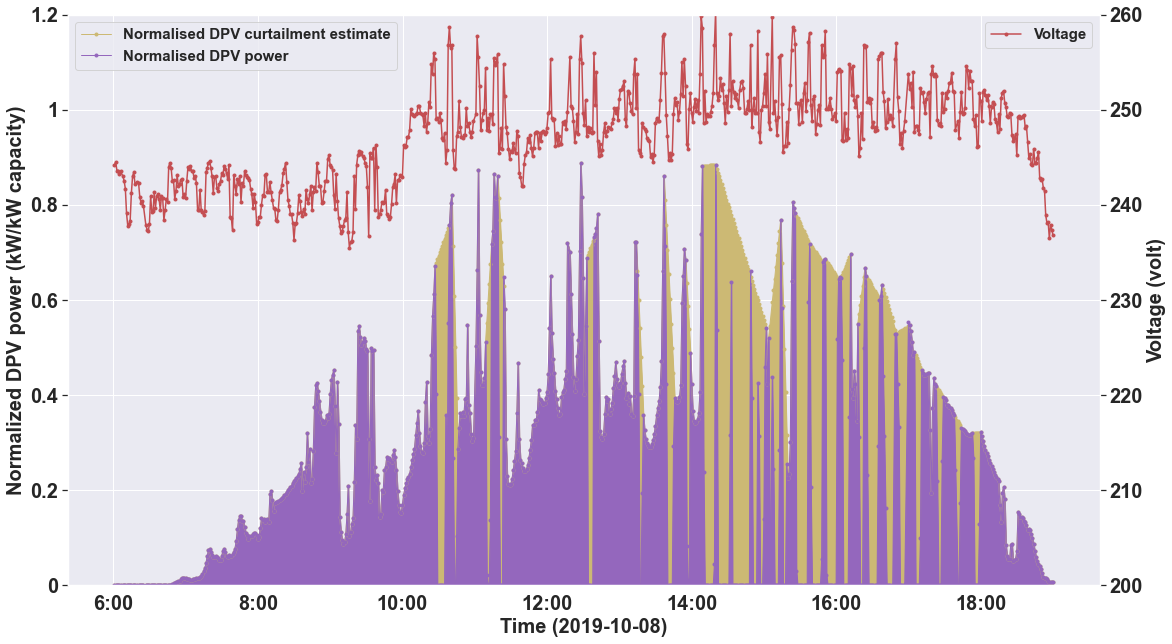

Perentage curtailed is 37.027023500521445 %
Analyzing date 2019-10-09


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:647: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

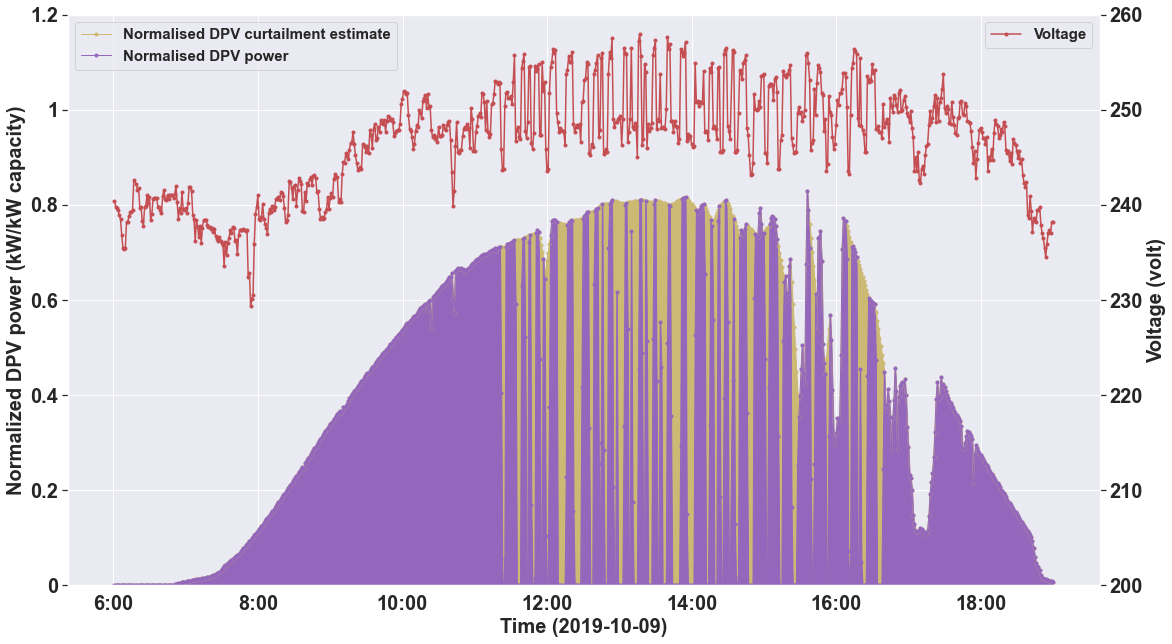

Perentage curtailed is 30.391266739495208 %
Analyzing date 2019-10-10


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:647: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

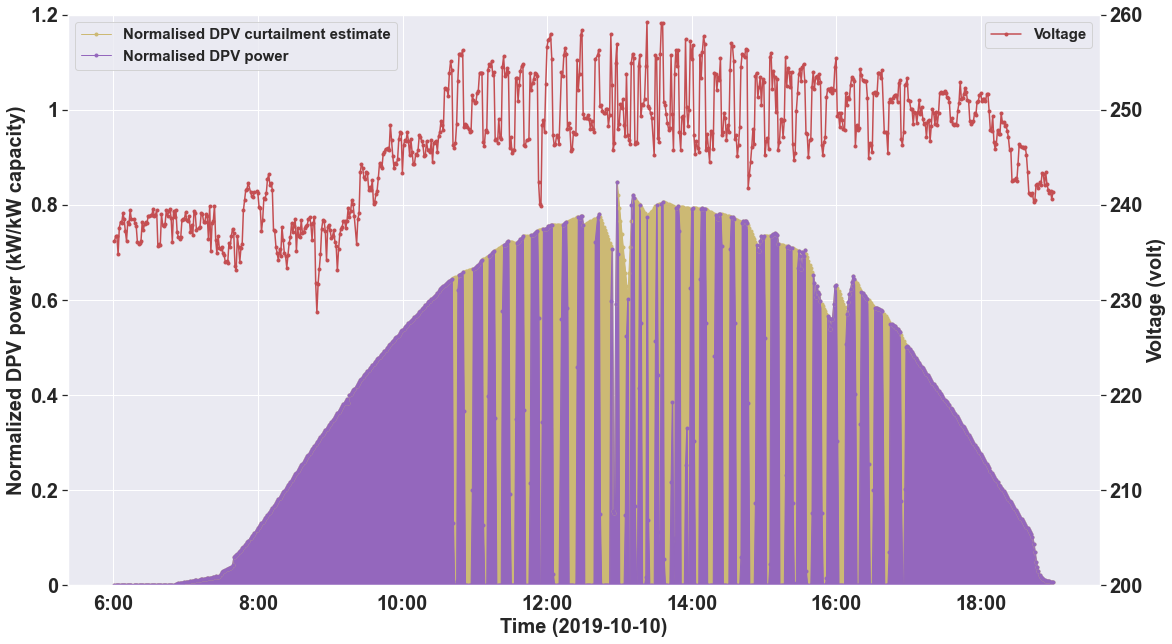

Perentage curtailed is 35.751289177021626 %
Analyzing date 2019-10-11


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:647: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

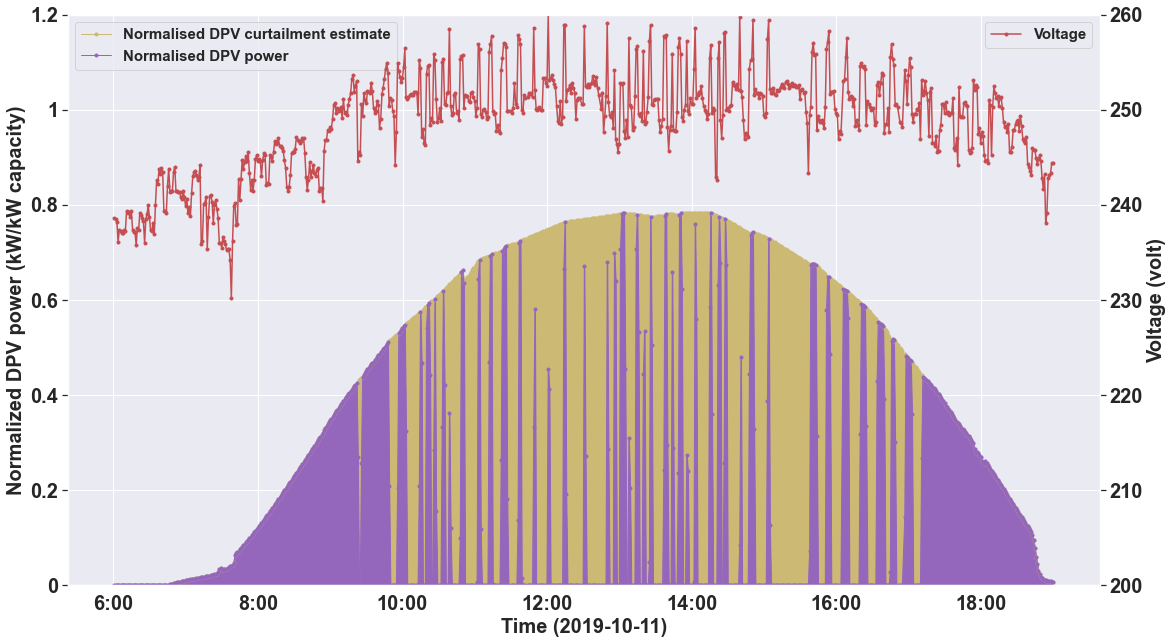

Perentage curtailed is 62.22582510429542 %
Analyzing date 2019-10-15


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:647: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

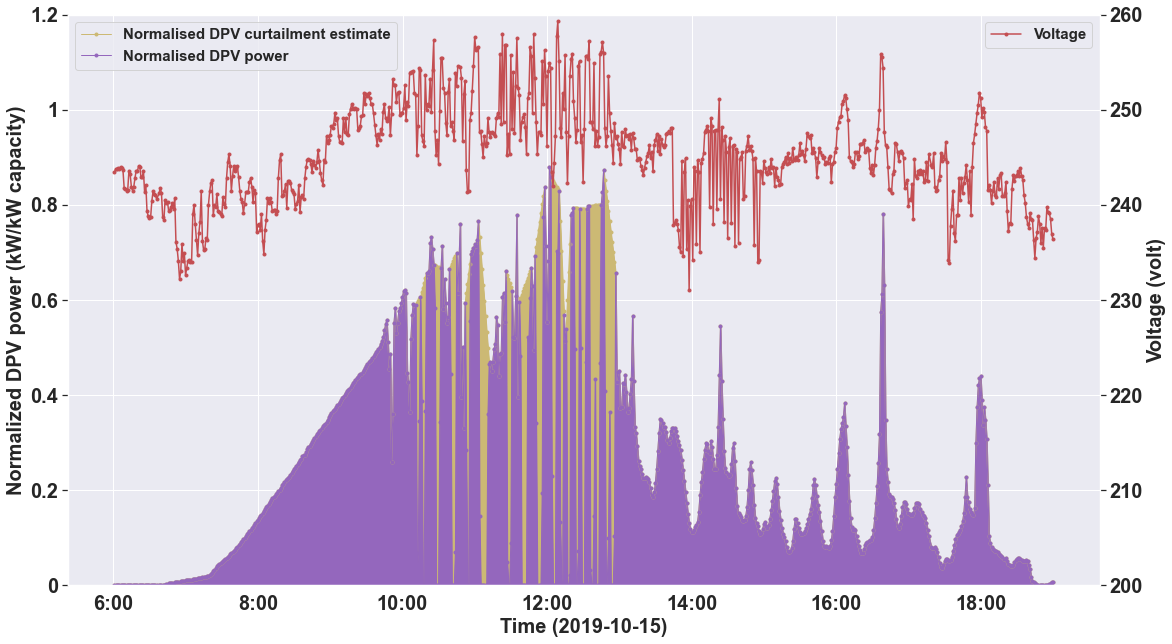

Perentage curtailed is 21.658245934914657 %


In [122]:
c_id = 1317822057
month_analyzed = '201910'
site_id_filter = data[month_analyzed]['c_id'] == c_id
data_certain_site = data[month_analyzed].loc[site_id_filter]

for date in date_analyzed_tripping_ncsd:
    print('Analyzing date {}'.format(date))
    #filter D-PV time series data
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    date_filter = data_certain_site['date'] == date_dt
    data_analyzed = data_certain_site.loc[date_filter]
    #check tripping curtailment
    size_is_ok = file_processing.check_data_size(data_analyzed)
    if not size_is_ok:
        print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
    else:
        data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
        data_site = file_processing.resample_in_minute(data_site)

        if date in csd_list:
            is_clear_sky_day = True
        else:
            is_clear_sky_day = False

        tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
        energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
        
        plot_curtailment(data_site, date, ac_cap)
        
        percentage_curtailed = tripping_curt_energy / (tripping_curt_energy + energy_generated) * 100
        print('Perentage curtailed is {} %'.format(percentage_curtailed))


# ANALYZE A SITE FOR A CERTAIN DAY

Just for testing purpose. It is not used in the actual script deployment

In [22]:
c_id = 1317822057
date = '2019-10-11'

In [23]:
print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
#filter D-PV time series data
date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
month_analyzed = date[:4] + date [5:7]

date_filter = data[month_analyzed].date == date_dt
site_id_filter = data[month_analyzed]['c_id'] == c_id
data_analyzed = data[month_analyzed].loc[date_filter & site_id_filter]

#check tripping curtailment
size_is_ok = file_processing.check_data_size(data_analyzed)
if not size_is_ok:
    print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
else:
    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
    data_site = file_processing.resample_in_minute(data_site)

Analyzing c_id 1317822057 date 2019-10-11 ...


In [27]:
#check tripping curtailment
size_is_ok = file_processing.check_data_size(data_analyzed)
if not size_is_ok:
    print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
else:
    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
    data_site = file_processing.resample_in_minute(data_site)

    if date in csd_list:
        is_clear_sky_day = True
    else:
        is_clear_sky_day = False

    tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
    energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)

    total_energy_generation += energy_generated

    if tripping_curt_energy > 0:
        count_curtailment += 1
        total_tripping_curtailment += tripping_curt_energy

C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:647: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

NameError: name 'total_energy_generation' is not defined

In [28]:
energy_generated

11.481263378201248

In [29]:
tripping_curt_energy

18.91321488611901

In [32]:
(data_site['power']*60/3600).sum()

11381.259444444444

In [30]:
estimation_method

'linear'

<AxesSubplot:xlabel='Timestamp'>

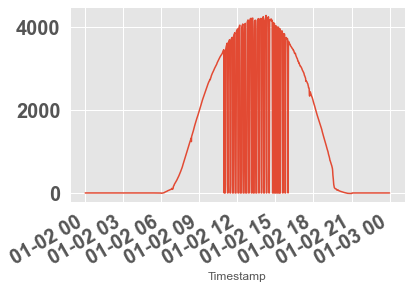

In [12]:
data_analyzed['power'].plot()

# MESSY BELOW

In [ ]:
is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date

In [36]:
tripping_curt_energy

18.91321488611901

In [37]:
generated_energy

24.16977710834123

<AxesSubplot:xlabel='ts'>

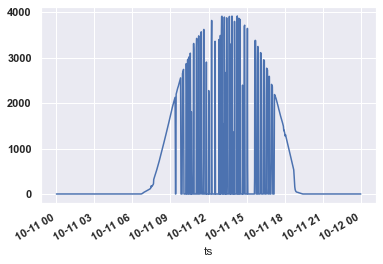

In [43]:
data_site['power'].plot()

In [50]:
(data_site['power_expected_linear']*60/3600).sum()/1000

30.294474330563453

In [53]:
(data_site['power']*60/3600).sum()/1000

11.381259444444444

In [54]:
tripping_curt_energy

18.91321488611901